In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn

import plotly.graph_objects as go
import plotly.express as px

# Train a surrogate infection model based on a feedforward neural network

In [2]:
# read in data
df = pd.read_csv("processed_data/processed_hABM_output_ALL.csv", index_col=0)
df.head(5)

,run_id,rupAM,t0sAEC,rupAEC1,icNum,Time,Mean Radius,On AEC1,On AEC2,On AEC1 rel,On AEC2 rel,Taken up by AEC1 rel,Taken up by AEC2 rel,Taken up by AMs,Total taken up by AECs,Total taken up
0,0,0.00137,0.0,0.000137,0.0,0,1.390000,0.9532,0.0468,1.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0000
1,0,0.00137,0.0,0.000137,0.0,30,1.395055,0.9495,0.0444,0.996118,0.948718,0.003882,0.051282,0.0,0.0061,0.0061
2,0,0.00137,0.0,0.000137,0.0,60,1.407814,0.9449,0.0430,0.991292,0.918803,0.008708,0.081197,0.0,0.0121,0.0121
3,0,0.00137,0.0,0.000137,0.0,90,1.449926,0.9407,0.0414,0.986886,0.884615,0.013114,0.115385,0.0,0.0179,0.0179
4,0,0.00137,0.0,0.000137,0.0,120,1.558986,0.9359,0.0393,0.981851,0.839744,0.018149,0.160256,0.0,0.0248,0.0248


In [3]:
# input data
df.iloc[:, 1:6].head(5)

,rupAM,t0sAEC,rupAEC1,icNum,Time
0,0.00137,0.0,0.000137,0.0,0
1,0.00137,0.0,0.000137,0.0,30
2,0.00137,0.0,0.000137,0.0,60
3,0.00137,0.0,0.000137,0.0,90
4,0.00137,0.0,0.000137,0.0,120


In [4]:
# normalize input for neural network
inputdf = df.iloc[:, 1:6]
inputdf["rupAM"] = np.log(inputdf["rupAM"])
inputdf["rupAEC1"] = np.log(inputdf["rupAEC1"])
inputdf_n = (inputdf - inputdf.min())/(inputdf.max() - inputdf.min())
inputdf_n.head(5)

,rupAM,t0sAEC,rupAEC1,icNum,Time
0,0.0,0.0,0.0,0.0,0.0000
1,0.0,0.0,0.0,0.0,0.0625
2,0.0,0.0,0.0,0.0,0.1250
3,0.0,0.0,0.0,0.0,0.1875
4,0.0,0.0,0.0,0.0,0.2500


In [5]:
# output data (already normalized)
outputdf = df.iloc[:, 13:15]
outputdf.head(5)

,Taken up by AMs,Total taken up by AECs
0,0.0,0.0000
1,0.0,0.0061
2,0.0,0.0121
3,0.0,0.0179
4,0.0,0.0248


In [6]:
# Class for feed forward Multilayer Perceptron (MLP) (Neural network)
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size3, output_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size3 = hidden_size3
        self.hl1 = nn.Linear(self.input_size, self.hidden_size)
        self.hl3 = nn.Linear(self.hidden_size, self.hidden_size3)
        self.sigmoid = nn.Sigmoid()
        self.output_layer = torch.nn.Linear(self.hidden_size3, output_size)

    def forward(self, x):
        act_fun = nn.Sigmoid()
        hidden = act_fun(self.hl1(x))
        hidden3 = act_fun(self.hl3(hidden))
        output = self.output_layer(hidden3)
        return output

    def optimize_net(self, data, target, epoch=25000, startval=False, lr=0.001):
        if startval:
            optimizer = torch.optim.Adam(startval, lr=lr)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            
        self.train()
        for epoch in range(epoch):
            optimizer.zero_grad()
            pred = self(data)  # get predictions NN(w)(x_i) of the current model on the data
            loss = self.custom_loss(pred.squeeze(), target)
            if epoch%500000 == 0:
                print("Epoch:", epoch, "- Loss:", loss.item())

            loss.backward()  # compute gradients
            optimizer.step()  # do a gradient descend step
            
    def custom_loss(self, y_pred, y_true):
        # Regular MSE loss
        mse_loss = torch.nn.functional.mse_loss(y_pred, y_true)

        # Penalty for y1 and y2 being negative
        penalty1 = torch.relu(-y_pred[:, 0]) + torch.relu(-y_pred[:, 1])

        # Penalty for y1 + y2 > 1
        penalty2 = torch.relu(y_pred[:, 0] + y_pred[:, 1] - 1.0)
        
        # print(penalty1.mean().item(), penalty2.mean().item())

        # Combine the losses with weight factors (alpha and beta are hyperparameters)
        # alpha, beta = 0.0001, 0.0001
        total_loss = mse_loss# + alpha * penalty1 + beta * penalty2

        return total_loss.mean()

    def rmse(self, data, target):
        criterion = torch.nn.MSELoss()
        pred = self(data)
        return torch.sqrt(criterion(pred.squeeze(), target)).item()

    def absloss(self, data, target):
        criterion = torch.nn.L1Loss()
        pred = self(data)
        return criterion(pred.squeeze(), target).item()
    
def to_tensor(variab: list, infsc: list) -> list:
    variabs_t = []
    for x in variab.transpose():
        variabs_t.append(x)
    
    targets_t = []
    for y in infsc:
        targets_t.append(y)
    
    data = torch.tensor(variabs_t, dtype=torch.float32).t()
    target = torch.tensor(targets_t, dtype=torch.float32)
    return data, target

In [7]:
# define feedforward network with 5 input layers, 21, 11 hidden layers and 2 output layers
model = Feedforward(5, 21, 11, 2)
# define input and output (target) data
data, target = to_tensor(np.array(inputdf_n), np.array(outputdf))

# optimize model
# model.optimize_net(data, target, epoch=1000000)
# startval_ = model.parameters()
# print("new learning rate")
# model.optimize_net(data, target, epoch=2000000, startval=startval_, lr=0.0005)

# load model in case it is already trained
model.load_state_dict(torch.load('surrogate_infection_model_5_21_11_2.pth'))

# define function for model prection with normalized input
def input_normalize(inp):
    inp[0] = np.log(inp[0])
    inp[2] = np.log(inp[2])
    return (inp - inputdf.min())/(inputdf.max() - inputdf.min())

def modelp(inp):
    vals = input_normalize(inp)
    output = model(torch.tensor(vals, dtype=torch.float32))
    return output

# calculate current MSE to data
criterion = torch.nn.MSELoss()
criterion(model(data), target).item()

/tmp/ipykernel_1379635/1236613153.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data = torch.tensor(variabs_t, dtype=torch.float32).t()


2.634857992234174e-05

In [8]:
# save model 
# torch.save(model.state_dict(), 'surrogate_infection_model_5_21_11_2.pth')

# Model predictions (showcases)

In [9]:
# on input rupAM = 0.1,  t0sAEC = 90, rupAEC1 = 0.00137, icNum (number of AMs) = 12 after 360 mins
# output taken up by AMs (77.8%) vs taken up by AECs (21.7%)
modelp([0.1, 90, 0.00137, 12, 360])

tensor([0.7787, 0.2169], grad_fn=<AddBackward0>)

# SOBOL sensitivity analysis

In [10]:
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['$\large{r_{up0}^{AM}}$', '$\large{t_{s_{AEC}}}$', '$\large{r_{up0}^{AEC1}}$', '$\large{n_{AM}}$'],
    'bounds': [[0.0, 6.59], [0.0, 240], [-2.3, 1.61], [0.0, 28]]
}

# Generate Sobol samples
param_values = saltelli.sample(problem, 10000)

# Define your model function
def modelpred(params):
    params = np.append(params, 360)
    params[0] = np.exp(params[0])*0.00137
    params[2] = np.exp(params[2])*0.00137
    pred = modelp(params)
    return np.array([pred[0].item(), pred[1].item()]) # Example model

allYs = np.array([modelpred(params) for params in param_values])

# Evaluate the model
Y1 = np.array([params[0] for params in allYs])
Y2 = np.array([params[1] for params in allYs])

/home/csaffer/datana/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_1379635/270707896.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 10000)
/home/csaffer/datana/lib/python3.8/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


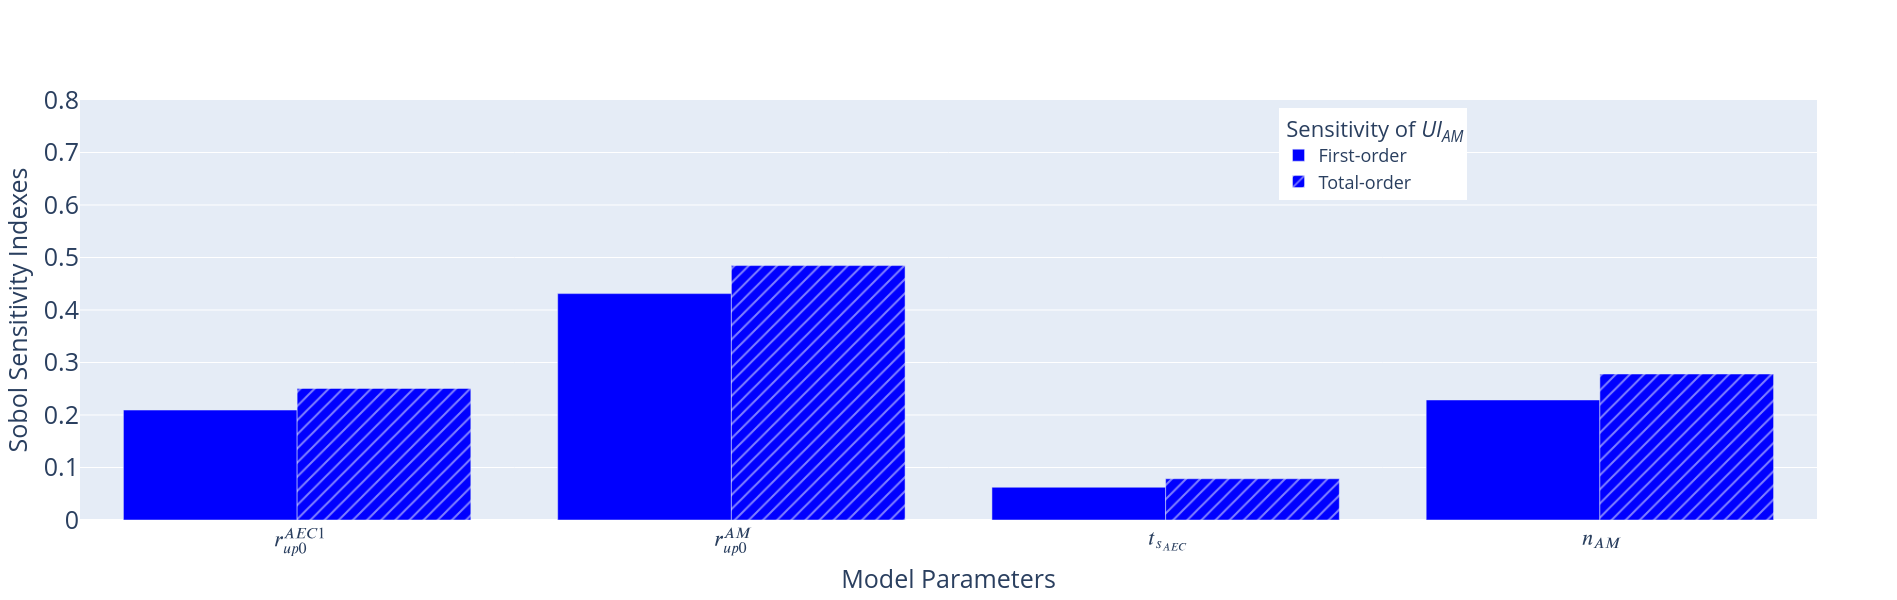

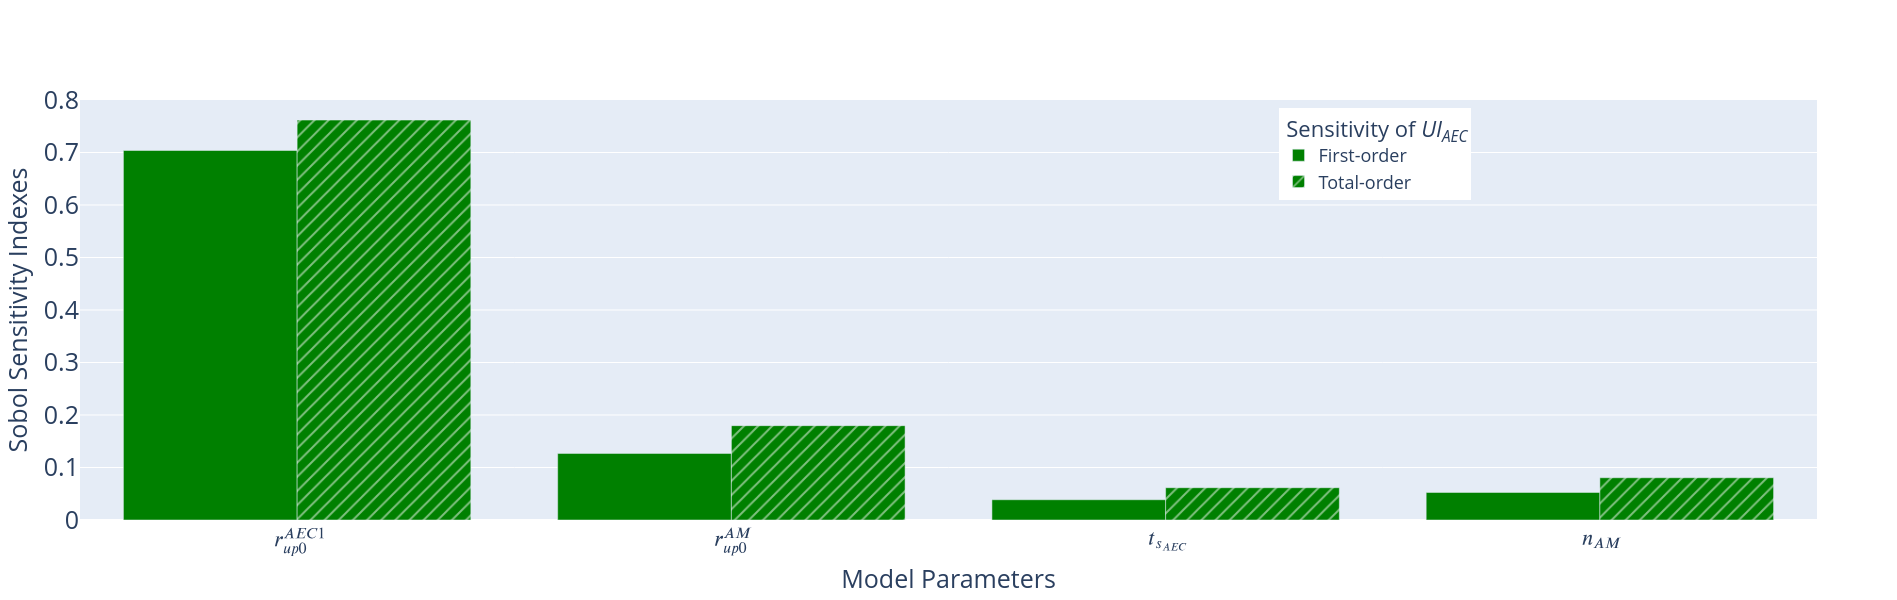

In [12]:
Y_outputs = [Y1, Y2]
titles = ['AM', 'AEC']

# Reorder indices
reordered_indices = [2, 0, 1, 3]
labels = [problem['names'][i] for i in reordered_indices]

# Plot Sobol sensitivity indices for each output
for Y, title in zip(Y_outputs, titles):
    Si = sobol.analyze(problem, Y)
    
    co = "green"
    if title == "AM":
        co = "blue"

    # Extract and reorder the Sobol indices
    S1 = [Si['S1'][i] for i in reordered_indices]
    ST = [Si['ST'][i] for i in reordered_indices]

    # Create the plot
    fig = go.Figure()

    # Add bars for first-order indices
    fig.add_trace(go.Bar(
        x=labels, y=S1, name='First-order', marker=dict(color=co)#, pattern_shape="x")
    ))

    # Add bars for total-order indices
    fig.add_trace(go.Bar(
        x=labels, y=ST, name='Total-order', marker=dict(color=co, pattern_shape="/")
    ))

    # Update layout for the plot
    fig.update_layout(
        title='',
        xaxis_title='Model Parameters',
        yaxis_title='Sobol Sensitivity Indexes',
        yaxis_range=[0, 0.8],
        font=dict(size=18),  # Change this value as needed to adjust the font size
        xaxis=dict(tickfont=dict(size=25), title_font=dict(size=25)),
        yaxis=dict(tickfont=dict(size=25), title_font=dict(size=25)),
        barmode='group',
        width=800,
        height=600,
        legend=dict(x=0.69, y=0.98, title=" Sensitivity of <i>UI<sub>"+str(title)+"</sub></i>"),
    )

    # Show the plot
    fig.show()
    fig.write_image("FigureS3_"+str(title)+".png")